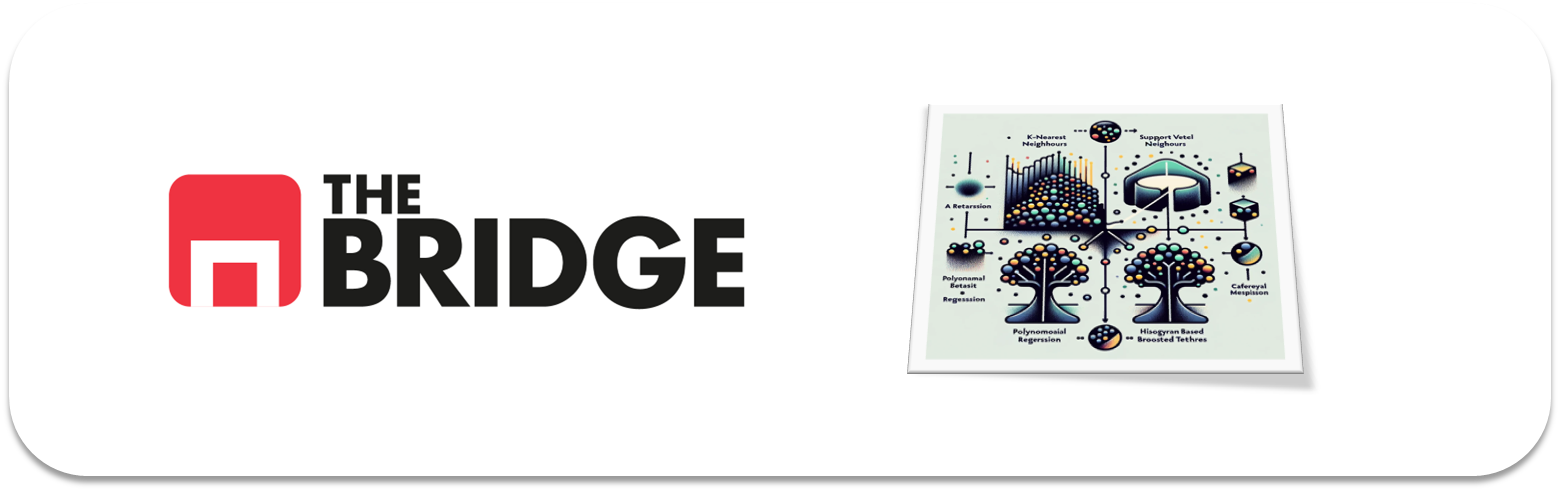

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [2]:
df = pd.read_csv("./data/credit_npo.csv")

In [3]:
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12532,0,0.197116,59,0,0.290216,5140.0,6,0,1,0,0.0
12533,0,0.036726,62,0,0.884985,5833.0,12,0,1,0,0.0
12534,0,0.120313,49,0,0.577676,6333.0,7,0,2,0,2.0
12535,0,0.252566,63,0,0.037640,14000.0,9,0,0,0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

1. SeriousDlqin2yrs  
Valor 1 = la persona tuvo morasidad grave (más de 90 días de atraso) en los últimos 2 años.  
Valor 0 = no tuvo morasidad grave.  

2. RevolvingUtilizationOfUnsecuredLines  
Porcentaje de uso de líneas de crédito no garantizadas (tarjetas, líneas personales).  
Valores >1 indican sobreendeudamiento o datos atípicos.

3. age  
Edad del cliente en años.  

4. NumberOfTime30-59DaysPastDueNotWorse  
Número de veces que el cliente estuvo 30 a 59 días retrasado en sus pagos (pero no peor).  
Mide retrasos moderados de pago.

5. DebtRatio  
Relación deuda / ingreso.  
Incluye pagos mensuales de deuda divididos entre ingreso mensual.  
Valores altos = mayor presión financiera.

6. MonthlyIncome  
Ingreso mensual del cliente.  
Tiene nulos.

7. NumberOfOpenCreditLinesAndLoans  
Número total de créditos y líneas abiertas.  
Incluye tarjetas, préstamos personales, hipotecas, etc.  

8. NumberOfTimes90DaysLate  
Número de veces que el cliente estuvo 90 días o más con retrasos en el pago.  
Es uno de los indicadores más fuertes de riesgo.  

9. NumberRealEstateLoansOrLines  
Número de préstamos o líneas asociadas a bienes raíces (hipotecas, créditos inmobiliarios).  

10. NumberOfTime60-89DaysPastDueNotWorse  
Número de veces que el cliente estuvo 60 a 89 días con retrasos en el pago.  
Retrasos serios, pero aún no mora grave.

11. NumberOfDependents  
Número de personas dependientes económicamente del cliente.  
Puede afectar la capacidad de pago.
Tiene nulos. 

In [5]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,12537.000000,12537.000000,12537.000000,12537.000000,12537.000000,11816.000000,12537.000000,12537.000000,12537.000000,12537.000000,12360.000000
mean,0.068916,0.330359,52.079445,0.409588,1.902253,6864.815420,8.482332,0.259312,0.999202,0.228364,0.822087
std,0.253321,0.368148,15.077498,4.055787,9.122216,11855.905437,5.165422,4.035658,1.134325,4.018873,1.136802
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030651,41.000000,0.000000,0.142268,3498.750000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.163490,51.000000,0.000000,0.302025,5416.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.582219,62.000000,0.000000,0.506725,8300.000000,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,6.000000,101.000000,98.000000,99.000000,702500.000000,49.000000,98.000000,19.000000,98.000000,10.000000


### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

Clasificación binaria. Tendrá o no problemas en los próximos 2 años.
La columna target será "SeriousDiquin2yrs".

### #1.3
Pinta la distribución de frecuencias del target y coméntala

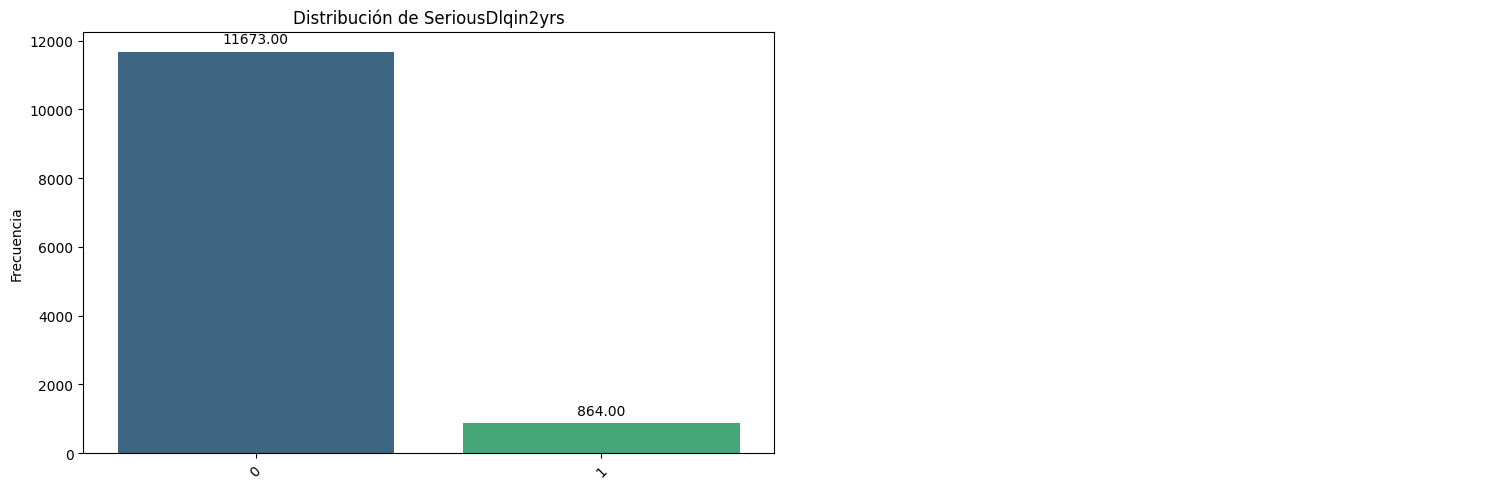

In [6]:
target = "SeriousDlqin2yrs"

bt.pinta_distribucion_categoricas(df,[target], mostrar_valores= True, relativa=False)

In [ ]:
# El target esta muy desbalanceado. 

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

In [7]:
# Train/test 

train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

In [8]:
# Imputaciones

# Crear indicador de nulo
train_set["Income_null"] = train_set["MonthlyIncome"].isna().astype(int)
test_set["Income_null"] = test_set["MonthlyIncome"].isna().astype(int)

# Calcular mediana
income_median = train_set["MonthlyIncome"].median()
income_median = test_set["MonthlyIncome"].median()

# Imputar
train_set["MonthlyIncome"] = train_set["MonthlyIncome"].fillna(income_median)
test_set["MonthlyIncome"] = test_set["MonthlyIncome"].fillna(income_median)


In [9]:
# Crear indicador de nulo
train_set["Dependents_null"] = train_set["NumberOfDependents"].isna().astype(int)
test_set["Dependents_null"] = test_set["NumberOfDependents"].isna().astype(int)

# Imputar con 0
train_set["NumberOfDependents"] = train_set["NumberOfDependents"].fillna(0)
test_set["NumberOfDependents"] = test_set["NumberOfDependents"].fillna(0)

In [18]:
train_set.drop(columns=['Income_null', 'Dependents_null'])
test_set.drop(columns=['Income_null', 'Dependents_null'])

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
9525,0,0.281116,69,0,0.162186,4500.0,10,0,0,0,1.0
2984,0,0.000000,38,0,0.987605,2500.0,6,0,2,0,1.0
6247,0,0.037880,29,1,0.257721,4500.0,10,0,0,0,0.0
9931,0,1.109863,56,0,0.111349,1400.0,1,1,0,1,0.0
7354,0,0.410206,59,0,1.574739,2200.0,6,0,2,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2666,0,0.151457,37,0,0.138972,5000.0,10,0,0,0,0.0
6522,0,0.869042,62,0,0.453104,6556.0,11,0,1,0,0.0
10692,0,0.000694,47,2,0.538731,2000.0,7,0,1,0,1.0
8291,0,0.519150,50,0,0.362577,7465.0,15,0,1,0,1.0


In [10]:
train_set.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
Income_null                             0
Dependents_null                         0
dtype: int64

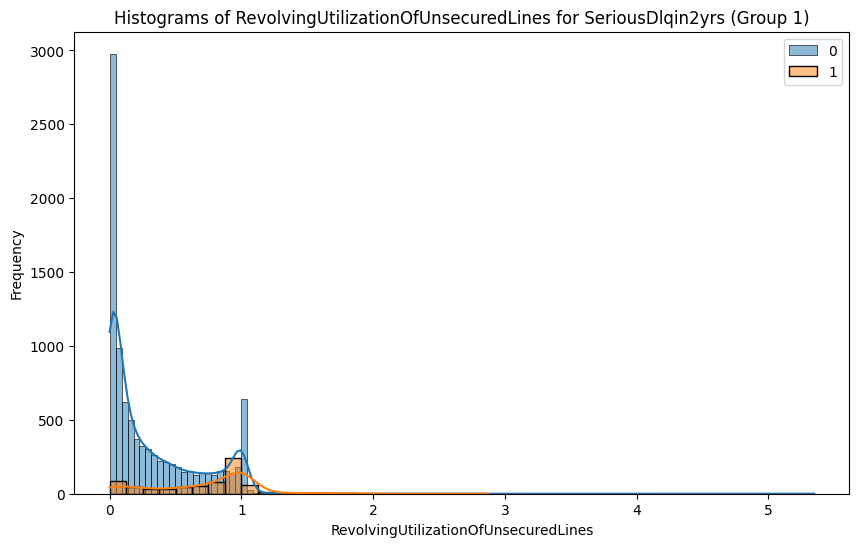

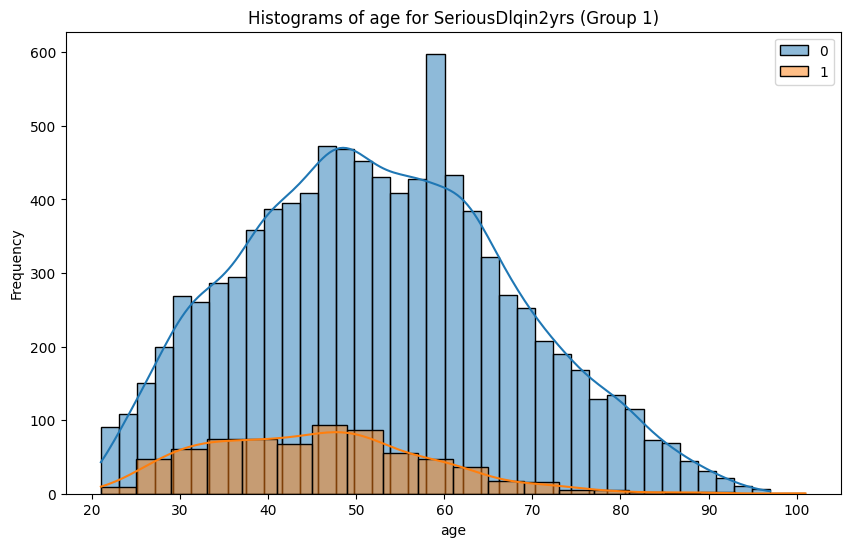

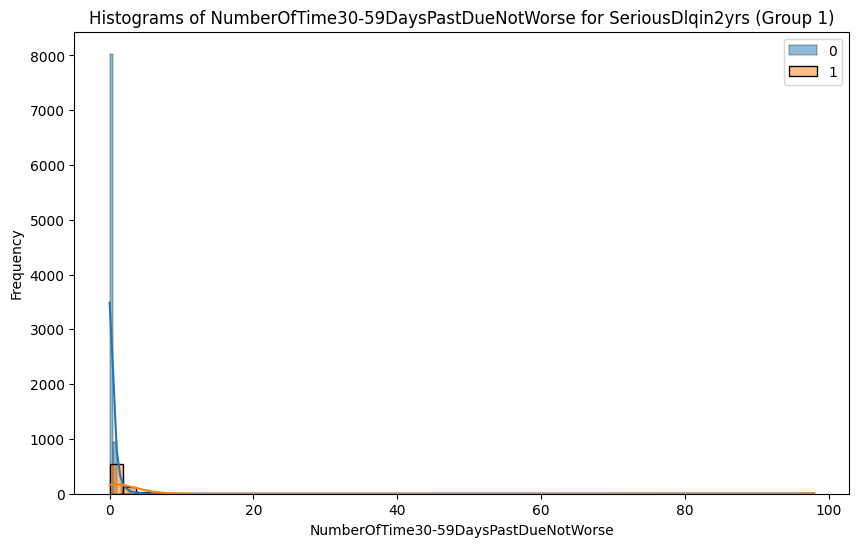

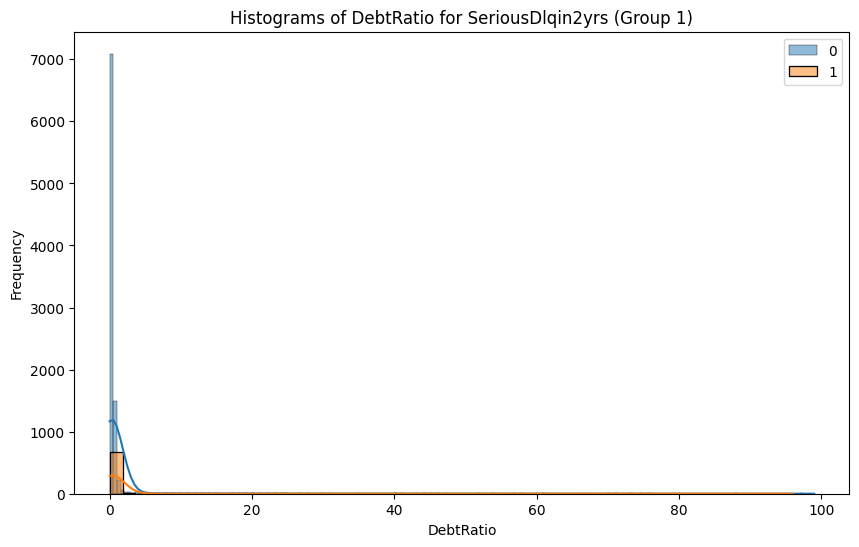

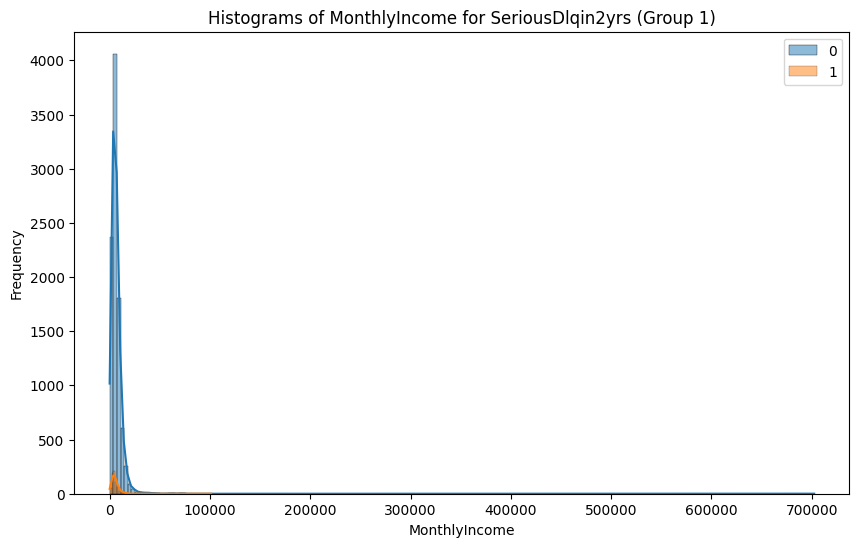

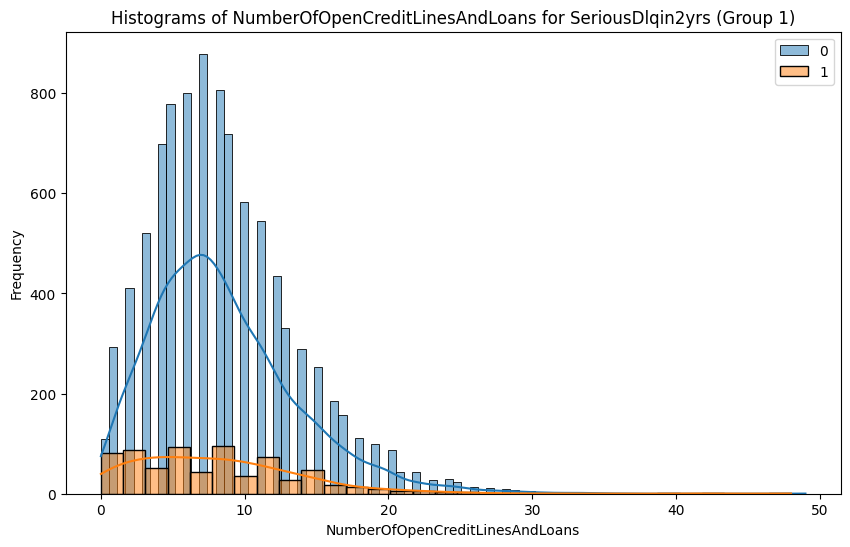

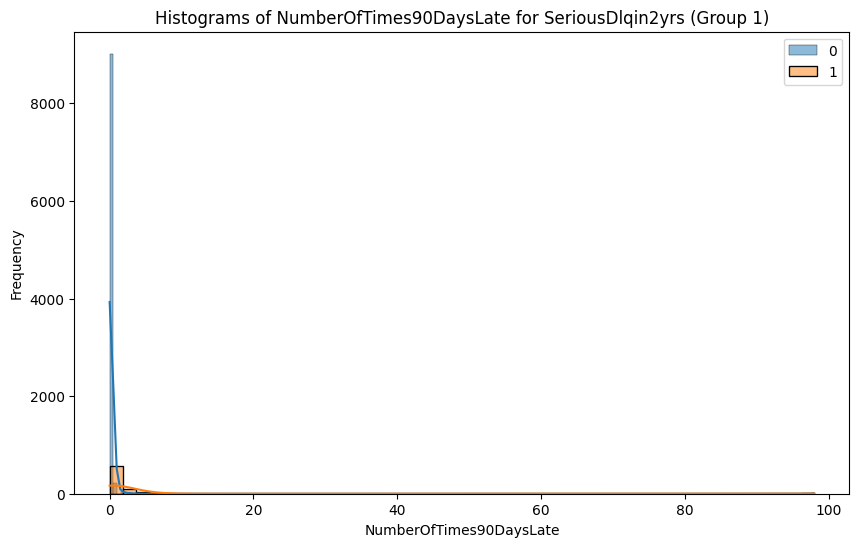

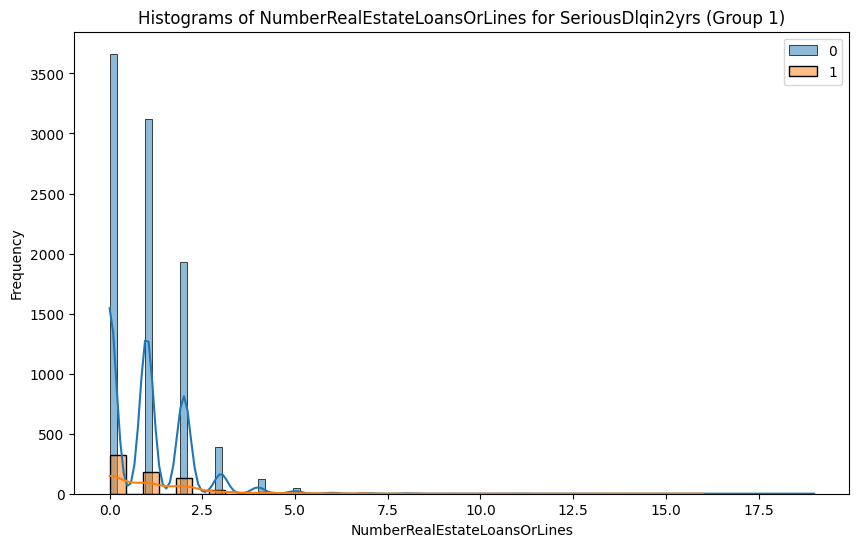

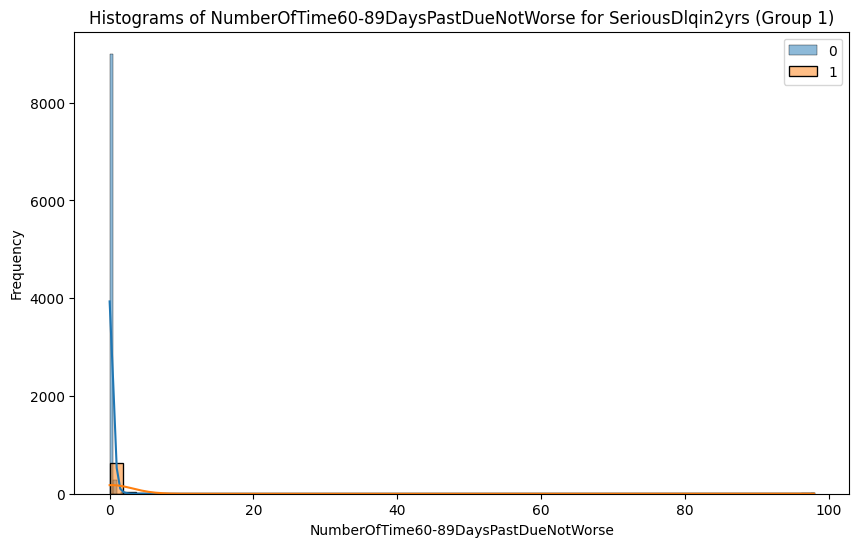

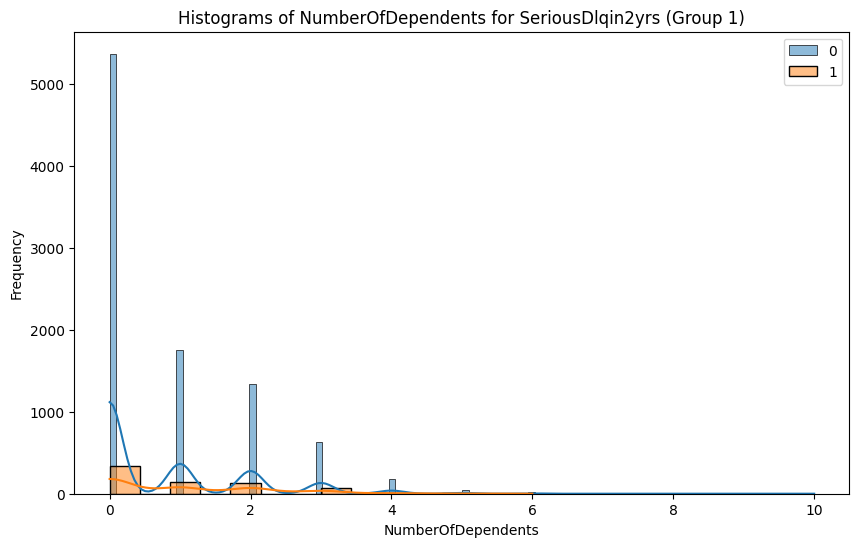

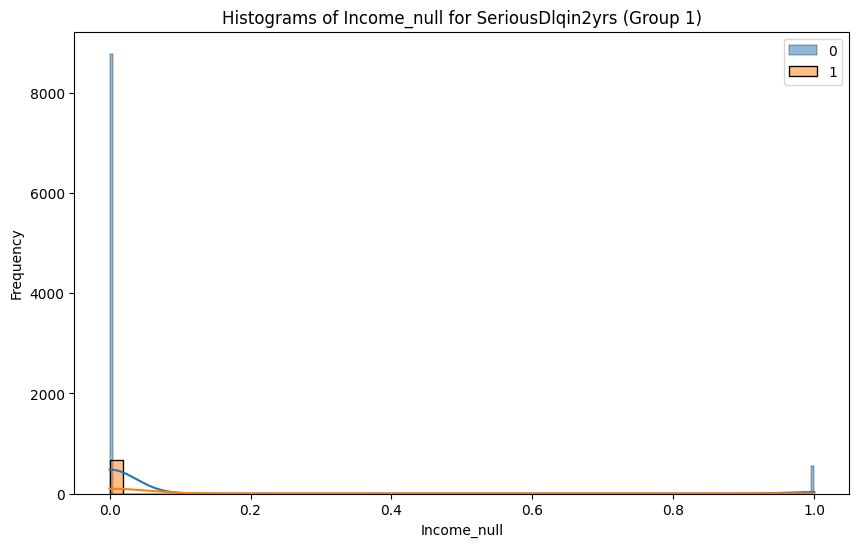

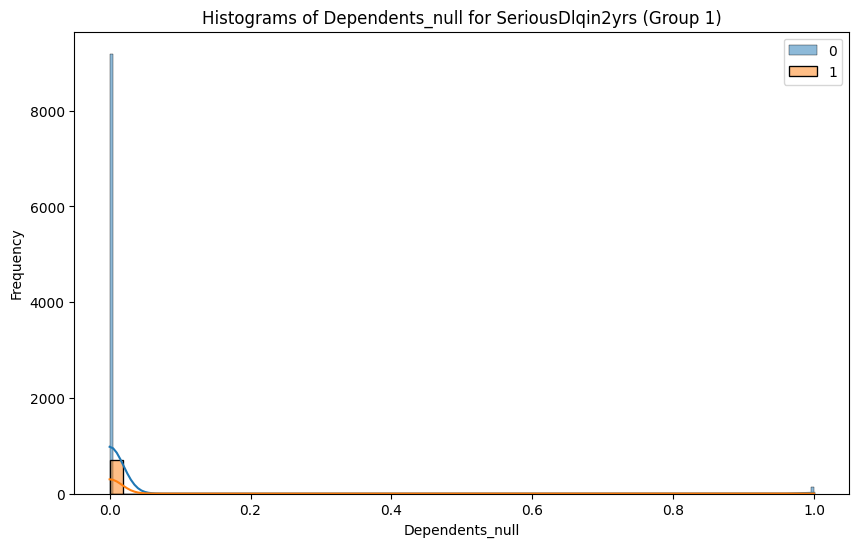

In [19]:
features = [col for col in train_set.columns if col != target]

for col in features:
    bt.plot_grouped_histograms(train_set, cat_col= target, num_col= col, group_size= 2)

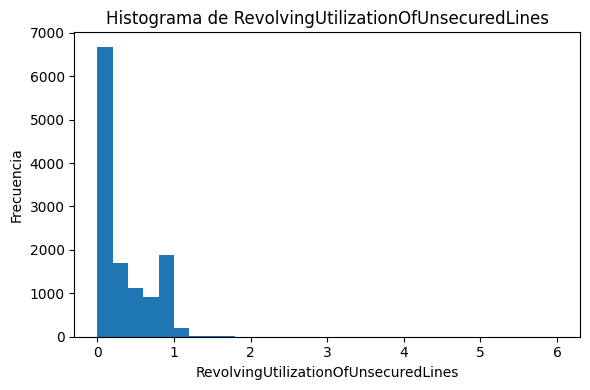

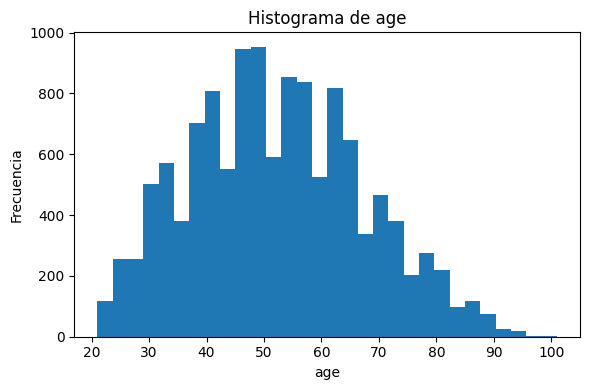

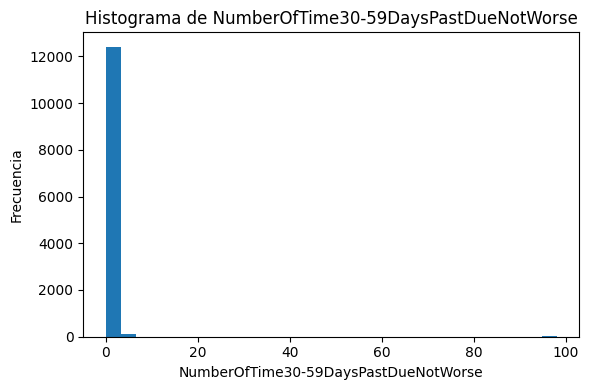

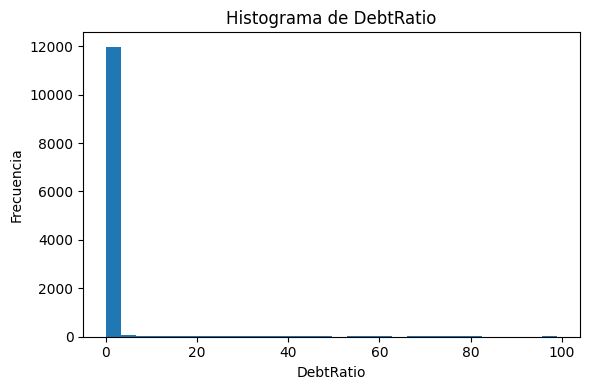

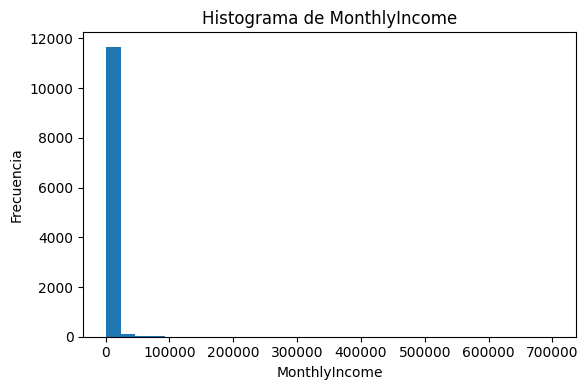

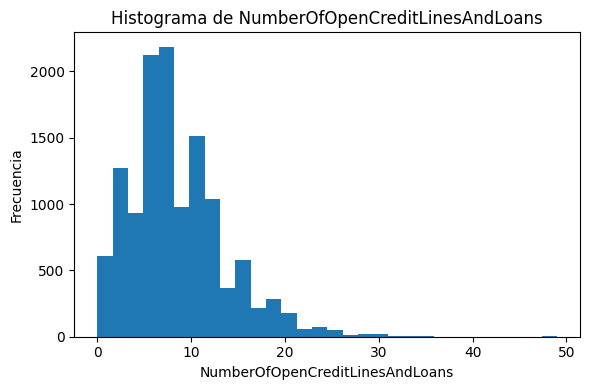

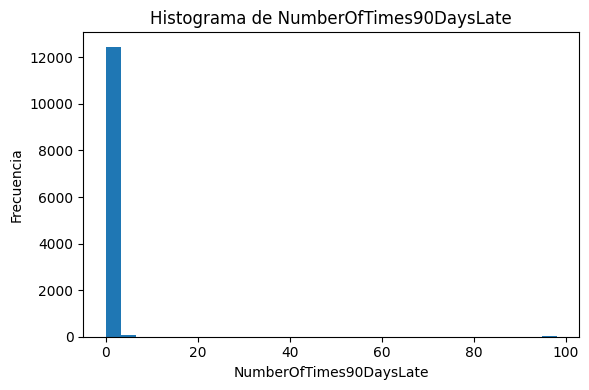

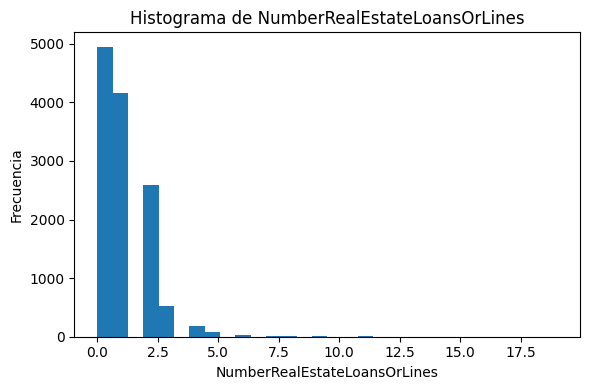

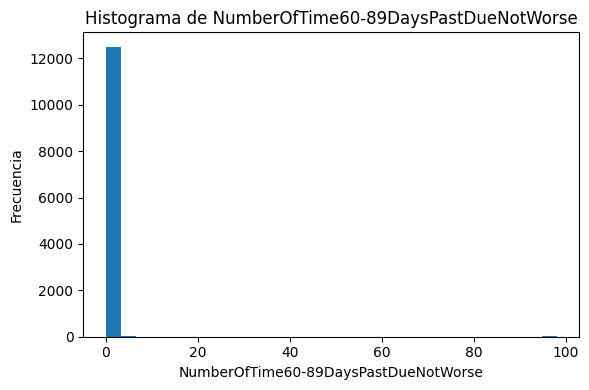

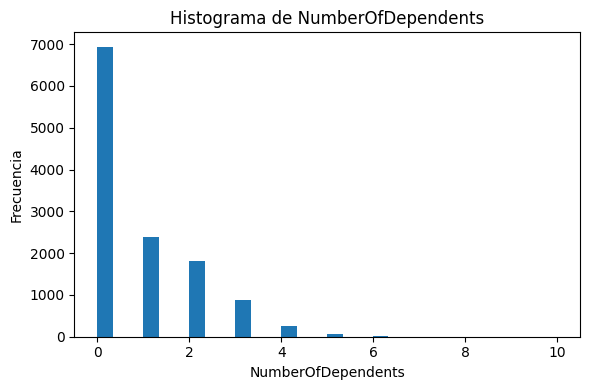

KeyError: 'Income_null'

<Figure size 600x400 with 0 Axes>

In [17]:
for col in features:
    plt.figure(figsize=(6,4))
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histograma de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

Voy a escalar todas menos "Age", parece que no lo necesita. 

In [14]:
train_set_escalado = train_set.copy()
test_set_escalado = test_set.copy()

In [15]:
for col in features:
    if col != "age":
        train_set_escalado[col] = np.log(train_set_escalado[col] + 1) 
        test_set_escalado[col] = np.log(test_set_escalado[col] + 1) # Lo que le hago al train, se lo hago al test

In [20]:
scaler = StandardScaler()

train_set_escalado[features] = scaler.fit_transform(train_set_escalado[features])
test_set_escalado[features] = scaler.transform(test_set_escalado[features])

In [21]:
# Ahora hacemos el X,y

X_train = train_set[features]
X_train_scaled = train_set_escalado[features]
y_train = train_set[target]

X_test = test_set[features]
X_test_scaled = test_set_escalado[features]
y_test = test_set[target]


In [26]:
# KNN

knn_clf = KNeighborsClassifier(n_neighbors= 5) 

knn_clf.fit(X_train_scaled, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [27]:
print(classification_report(y_train, knn_clf.predict(X_train_scaled)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      9328
           1       0.73      0.32      0.44       701

    accuracy                           0.94     10029
   macro avg       0.84      0.65      0.71     10029
weighted avg       0.94      0.94      0.93     10029



In [ ]:
modelos = ["KNN","Logistic","RandomF","XGBoost","LightGBM"] # Este código lo he sacado de las soluciones. 
metricas = []

lr_clf = LogisticRegression(max_iter = 15000)
rf_clf = RandomForestClassifier(max_depth = 6, random_state = 42)
xgb_clf = XGBClassifier(max_depth = 6, random_state = 42)
lgb_clf = LGBMClassifier(max_depth= 6, random_state = 42, verbose = -100, n_jobs= -1)

for nombre, modelo in zip(modelos,[knn_clf, lr_clf, rf_clf, xgb_clf, lgb_clf]):
    print(f"Para {nombre}:", end = " ")
    if nombre not in modelos[0:2]:
        metrica = np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
    else:
        metrica = np.mean(cross_val_score(modelo, X_train_scaled, y_train, cv = 5, scoring = "balanced_accuracy"))
    print(metrica)
    metricas.append(metrica)

Para KNN: 0.5917035050564364
Para Logistic: 0.5661184209233452
Para RandomF: 0.5433741142110176
Para XGBoost: 0.5938225488805573
Para LightGBM: 0.591879732943007


In [29]:
# Ahora vamos a equilibrar con SMOTE. Tanto el escalado como el no escalado. 

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

X_train_smote_scaled, y_train_smote_scaled = smote.fit_resample(X_train_scaled, y_train)

In [30]:
modelos = ["KNN","Logistic","RandomF","XGBoost","LightGBM"]
metricas = []

lr_clf = LogisticRegression(max_iter = 10000)
rf_clf = RandomForestClassifier(max_depth = 5, random_state = 42)
xgb_clf = XGBClassifier(max_depth = 5, random_state = 42)
lgb_clf = LGBMClassifier(max_depth= 5, verbose = -100, random_state = 42, n_jobs= -1)
model = []

for nombre,modelo in zip(modelos,[knn_clf, lr_clf, rf_clf, xgb_clf, lgb_clf]):
    model.append(modelo)
    print(f"Para {nombre}:", end = " ")
    if nombre not in modelos[0:2]:
        metrica = np.mean(cross_val_score(modelo, X_train_smote, y_train_smote, cv = 5, scoring = "balanced_accuracy"))
    else:
        metrica = np.mean(cross_val_score(modelo, X_train_smote_scaled, y_train_smote_scaled, cv = 5, scoring = "balanced_accuracy"))
    print(metrica)
    metricas.append(metrica)

Para KNN: 0.9052847771178332
Para Logistic: 0.7821612084744934
Para RandomF: 0.8180226660804749
Para XGBoost: 0.9133289943650882
Para LightGBM: 0.9010541394044408


In [31]:
# Ajuste de hiperparametros. Voy a quedarme con LightGBM porque XGBoost pasa del 90% y puede que este overfiteado 

param_grid = {
    "n_estimators": [100,200],
    "learning_rate": [0.1,0.5,1],
    "max_depth": [5,10,15],
    "min_data_in_leaf": [1,10,20,100]
}

lgb_clf = LGBMClassifier(verbose = -100)

lgb_grid_smote = GridSearchCV(lgb_clf,
                       param_grid= param_grid,
                       cv = 5,
                       scoring= "balanced_accuracy")

lgb_grid_smote.fit(X_train_smote,y_train_smote)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LGBMClassifier(verbose=-100)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'learning_rate': [0.1, 0.5, ...], 'max_depth': [5, 10, ...], 'min_data_in_leaf': [1, 10, ...], 'n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'balanced_accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fol

In [32]:
lgb_grid_smote.best_params_

{'learning_rate': 0.5,
 'max_depth': 10,
 'min_data_in_leaf': 1,
 'n_estimators': 200}

In [33]:
lgb_grid_smote.best_score_

np.float64(0.9394329456996802)

In [34]:
print(classification_report(y_test, lgb_grid_smote.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2345
           1       0.28      0.33      0.30       163

    accuracy                           0.90      2508
   macro avg       0.62      0.63      0.62      2508
weighted avg       0.91      0.90      0.90      2508

